# Sports Vector Machine

Support Vector Machines are powerful machine learning models that can make complex decision boundaries. An SVM’s decision boundary can twist and curve to accommodate the training data.

In this project, we will use an SVM trained using a baseball dataset to find the decision boundary of the strike zone.


The strike zone can be thought of as a decision boundary that determines whether or not a pitch is a strike or a ball. There is a strict definition of the strike zone: however, in practice, it will vary depending on the umpire or the player at bat.

Let’s use our knowledge of SVMs to find the real strike zone of several baseball players.


__We will load DataFrames related to some of baseball’s biggest stars, [Aaron Judge](https://www.mlb.com/player/aaron-judge-592450) and [Jose Altuve](https://www.mlb.com/player/jose-altuve-514888). Judge is one of the tallest players in the league and Altuve is one of the shortest. Their strike zones should be pretty different!__

Each row in these DataFrames corresponds to a single pitch that the batter saw in the 2017 season. 

Let's begin by importing the necessary libraries.

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


## 1. Aaron Judge sports vector machine

### Investigating the Aaron Judge dataset:

In [81]:
aaron_judge = pd.read_csv(r"C:\Users\amanp\OneDrive\Desktop\aaron_judge.csv")

In [82]:
aaron_judge.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,0,FF,2017-09-30,95.7,-2.3581,5.9240,Aaron Judge,592450,608678,strikeout,...,2,0,2,0,0,2,2,0,Standard,Standard
1,1,FF,2017-09-30,96.3,-2.5577,5.9023,Aaron Judge,592450,608678,NaN,...,2,0,2,0,0,2,2,0,Standard,Standard
2,2,FF,2017-09-30,95.2,-2.3861,5.8346,Aaron Judge,592450,608678,NaN,...,2,0,2,0,0,2,2,0,Standard,Standard
3,3,SI,2017-09-30,93.4,4.2502,4.6506,Aaron Judge,592450,571901,walk,...,2,0,2,0,0,2,2,0,Standard,Standard
4,4,SI,2017-09-30,92.8,4.1144,4.4696,Aaron Judge,592450,571901,NaN,...,2,0,2,0,0,2,2,0,Standard,Standard


 Each row in these DataFrames corresponds to a single pitch that the batter saw in the 2017 season. 
 
 Let’s take a look at all of the features of a pitch

In [83]:
aaron_judge.columns

Index(['Unnamed: 0', 'pitch_type', 'game_date', 'release_speed',
       'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher',
       'events', 'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'pos2_person_id', 'umpire',
       'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pos1_person_id',
       'pos2_person_id.1', 'pos3_person_id', 'pos4_person_id',
       'pos5_person_id', 'pos6_person_id', 'pos7_person_id', 'po

Some of these features have obscure names. Let’s learn what the feature description means by printing the different values the description feature could have.

In [84]:
print(aaron_judge.description.unique())

['swinging_strike' 'called_strike' 'ball' 'hit_into_play_score' 'foul'
 'blocked_ball' 'hit_into_play' 'hit_into_play_no_out'
 'swinging_strike_blocked' 'foul_tip' 'hit_by_pitch']


We’re interested in looking at whether a pitch was a ball or a strike. That information is stored in the type feature. Let's look at the unique values stored in the type feature to get a sense of how balls and strikes are recorded.

In [85]:
print(aaron_judge.type.unique())

['S' 'B' 'X']


Great! We know every row’s type feature is either an 'S' for a strike, a 'B' for a ball, or an 'X' for neither (for example, an 'X' could be a hit or an out).

We’ll want to use this feature as the label of our data points. However, instead of using strings, it will be easier if we change every 'S' to a 1 and every 'B' to a 0.

So let's use .map() function for the same.

In [86]:
aaron_judge['type'] = aaron_judge['type'].map({'S': 1, 'B': 0})

Let's print the 'type' column to see if our mapping worked.

In [87]:
aaron_judge['type']

0       1.0
1       1.0
2       1.0
3       0.0
4       1.0
       ... 
2984    1.0
2985    NaN
2986    0.0
2987    0.0
2988    NaN
Name: type, Length: 2989, dtype: float64

### Plotting the Pitches

We want to predict whether a pitch is a ball or a strike based on its location over the plate. We can find the ball’s location in the columns plate_x and plate_z.

Let's print aaron_judge['plate_x'] to see what that column looks like.

plate_x measures how far left or right the pitch is from the center of home plate. If plate_x = 0, that means the pitch was directly in the middle of the home plate.

In [88]:
print(aaron_judge['plate_x'])

0       1.0150
1       0.4546
2       0.0957
3       1.5161
4       0.0764
         ...  
2984   -0.3738
2985   -0.2953
2986    1.4094
2987    1.6717
2988   -0.1571
Name: plate_x, Length: 2989, dtype: float64


We now have the three columns we want to work with: 'plate_x', 'plate_z', and 'type'.

Let’s remove every row that has a NaN in any of those columns.

In [89]:
aaron_judge = aaron_judge.dropna(subset = ['plate_x', 'plate_z', 'type'])

We now have points to plot using Matplotlib. Let's call plt.scatter() using five parameters:

- The parameter x should be the plate_x column.
- The parameter y should be the plate_z column.
- To color the points correctly, the parameter c should be the type column.
- To make the strikes red and the balls blue, set the cmap parameter to plt.cm.coolwarm.
- To make the points slightly transparent, set the alpha parameter to 0.25.


plate_z measures how high off the ground the pitch was. If plate_z = 0, that means the pitch was at ground level when it got to the home plate.

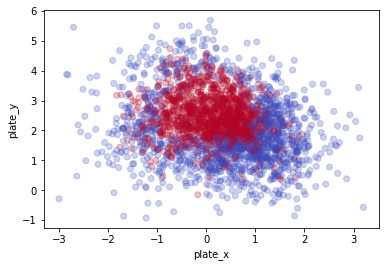

In [90]:
fig, ax = plt.subplots()
plt.scatter(x = aaron_judge['plate_x'], y = aaron_judge['plate_z'], c = aaron_judge['type'], cmap = plt.cm.coolwarm, alpha = 0.25)
plt.xlabel('plate_x')
plt.ylabel('plate_y')
plt.show()

### Building the SVM

Now that we’ve seen the location of every pitch, let’s create an SVM to create a decision boundary. This decision boundary will be the real strike zone for that player. 

To begin, we want to validate our model, so we need to split the data into a training set and a validation set.

Let's call the train_test_split function using aaron_judge as a parameter.

This function returns two objects. Let's store the return values in variables named training_set and validation_set.

In [91]:
training_set, validation_set = train_test_split(aaron_judge, random_state = 1)

Now, let's create an SVC named classifier with kernel = 'rbf'.


And call classifier‘s .fit() method. This method should take two parameters:

- The training data. This is the plate_x column and the plate_z column in training_set.
- The labels. This is the type column in training_set.

In [92]:
classifier = SVC(kernel = 'rbf')

classifier.fit(training_set[['plate_x', 'plate_z']], training_set['type'])

SVC()

To visualize the SVM, let's define a function called 'draw_boundary'.

This function takes two parameters:

- The axes of your graph. For us, this is the ax variable that we defined at the top of your code.
- The trained SVM. For us, this is classifier. 

In [93]:

def make_meshgrid(ax, h=.02):
    # x_min, x_max = x.min() - 1, x.max() + 1
    # y_min, y_max = y.min() - 1, y.max() + 1
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


def draw_boundary(ax, clf):

    xx, yy = make_meshgrid(ax)
    return plot_contours(ax, clf, xx, yy,cmap=plt.cm.coolwarm, alpha=0.5)


Let's call the draw boundary function to see the predicted strike zone!

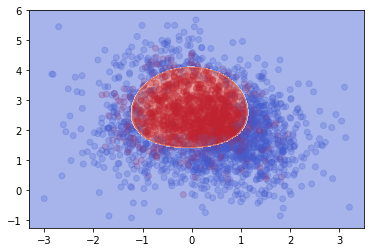

In [94]:
fig, ax = plt.subplots()
plt.scatter(x = aaron_judge['plate_x'], y = aaron_judge['plate_z'], c = aaron_judge['type'], cmap = plt.cm.coolwarm, alpha = 0.25)

draw_boundary(ax, classifier)
plt.show()

### Optimizing the SVM

 We’re now able to see the strike zone. But we don’t know how accurate our classifier is yet. Let’s find its accuracy by calling the .score() method and printing the results.

.score() takes two parameters — the points in the validation set and the labels associated with those points.

In [95]:
print(classifier.score(validation_set[['plate_x', 'plate_z']], validation_set['type']))

0.8295625942684767


__Let’s change some of the SVM’s parameters to see if we can get better accuracy.__

__Set the parameters of the SVM to be gamma = 100 and C = 100__

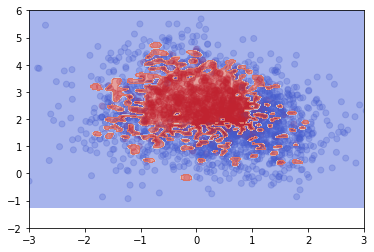

0.7933634992458521


In [96]:
classifier = SVC(kernel = 'rbf', gamma = 100, C = 100)

classifier.fit(training_set[['plate_x', 'plate_z']], training_set['type'])

fig, ax = plt.subplots()
plt.scatter(x = aaron_judge['plate_x'], y = aaron_judge['plate_z'], c = aaron_judge['type'], cmap = plt.cm.coolwarm, alpha = 0.25)

draw_boundary(ax, classifier)
ax.set_ylim(-2, 6)
ax.set_xlim(-3, 3)
plt.show()

print(classifier.score(validation_set[['plate_x', 'plate_z']], validation_set['type']))


This is an example of overfitting.

Let's try to find a configuration of gamma and C that greatly improves the accuracy by looping through different values of gamma and C and print the accuracy using those parameters.

In [97]:
largest = {'value': 0, 'gamma': 1, 'C': 1}
for gamma in range(1,10):
    for C in range(1,10):
        classifier = SVC(kernel='rbf', gamma = gamma, C = C)
        classifier.fit(training_set[['plate_x', 'plate_z']], training_set['type'])
        score = classifier.score(validation_set[['plate_x', 'plate_z']], validation_set['type'])
        if(score > largest['value']):
            largest['value'] = score
            largest['gamma'] = gamma
            largest['C'] = C

print(largest)

                

{'value': 0.8340874811463047, 'gamma': 1, 'C': 3}


So our best SVM has an accuracy of 83.4% with gamma = 1 and C = 3. 
Let's draw the decision boundary plot for this.

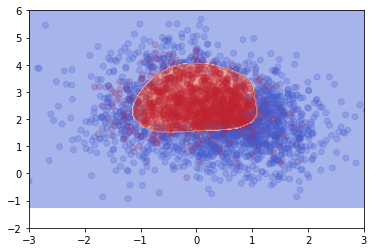

In [98]:
classifier = SVC(kernel = 'rbf', gamma = 1, C = 3)

classifier.fit(training_set[['plate_x', 'plate_z']], training_set['type'])

fig, ax = plt.subplots()
plt.scatter(x = aaron_judge['plate_x'], y = aaron_judge['plate_z'], c = aaron_judge['type'], cmap = plt.cm.coolwarm, alpha = 0.25)

draw_boundary(ax, classifier)
ax.set_ylim(-2, 6)
ax.set_xlim(-3, 3)
plt.show()


## 2. Jose Altuve sports vector machine

Now let's follow the same steps to find the best SVM for Jose Altuve

In [99]:
jose_altuve = pd.read_csv(r"C:\Users\amanp\OneDrive\Desktop\jose_altuve.csv")

In [100]:
jose_altuve.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,0,CH,2017-10-01,83.4,-1.4999,5.7160,Jose Altuve,514888,584171,field_out,...,0,0,0,0,0,0,0,0,Standard,Standard
1,1,SI,2017-10-01,88.6,-1.5817,5.8996,Jose Altuve,514888,584171,field_out,...,0,0,0,0,0,0,0,0,Standard,Standard
2,2,SL,2017-09-30,84.3,-2.5559,6.0617,Jose Altuve,514888,592665,field_out,...,6,2,2,6,2,6,2,6,Standard,Standard
3,3,SL,2017-09-30,86.8,-2.6507,5.8284,Jose Altuve,514888,592665,NaN,...,6,2,2,6,2,6,2,6,Standard,Standard
4,4,FF,2017-09-30,91.7,-2.4864,5.9947,Jose Altuve,514888,592665,NaN,...,6,2,2,6,2,6,2,6,Standard,Standard


In [101]:
jose_altuve.columns

Index(['Unnamed: 0', 'pitch_type', 'game_date', 'release_speed',
       'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher',
       'events', 'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'pos2_person_id', 'umpire',
       'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pos1_person_id',
       'pos2_person_id.1', 'pos3_person_id', 'pos4_person_id',
       'pos5_person_id', 'pos6_person_id', 'pos7_person_id', 'po

In [102]:
jose_altuve.type.unique()

array(['X', 'B', 'S'], dtype=object)

In [103]:
jose_altuve['type'] = jose_altuve['type'].map({'S': 1, 'B': 0})


In [104]:
jose_altuve.type

0       NaN
1       NaN
2       NaN
3       0.0
4       1.0
       ... 
2303    0.0
2304    0.0
2305    1.0
2306    1.0
2307    0.0
Name: type, Length: 2308, dtype: float64

In [105]:
jose_altuve = jose_altuve.dropna(subset = ['plate_x', 'plate_z', 'type'])

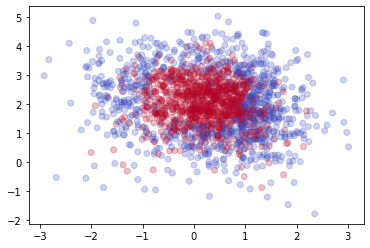

In [106]:
plt.scatter(x = jose_altuve['plate_x'], y = jose_altuve['plate_z'], c = jose_altuve['type'], cmap = plt.cm.coolwarm, alpha = 0.25)
ax.set_ylim(-2, 6)
ax.set_xlim(-3, 3)
plt.show()

In [107]:
training_set, validation_set = train_test_split(jose_altuve, random_state = 1)

In [108]:
classifier = SVC(kernel = 'rbf')

classifier.fit(training_set[['plate_x', 'plate_z']], training_set['type'])

print(classifier.score(validation_set[['plate_x', 'plate_z']], validation_set['type']))

0.8258928571428571


In [109]:
largest = {'value': 0, 'gamma': 1, 'C': 1}
for gamma in range(1,10):
    for C in range(1,10):
        classifier = SVC(kernel='rbf', gamma = gamma, C = C)
        classifier.fit(training_set[['plate_x', 'plate_z']], training_set['type'])
        score = classifier.score(validation_set[['plate_x', 'plate_z']], validation_set['type'])
        if(score > largest['value']):
            largest['value'] = score
            largest['gamma'] = gamma
            largest['C'] = C

print(largest)

{'value': 0.8325892857142857, 'gamma': 2, 'C': 7}


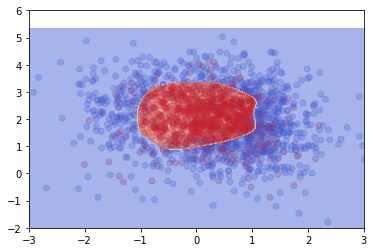

0.8325892857142857


In [110]:
classifier = SVC(kernel = 'rbf', gamma = 2, C = 7)

classifier.fit(training_set[['plate_x', 'plate_z']], training_set['type'])

fig, ax = plt.subplots()
plt.scatter(x = jose_altuve['plate_x'], y = jose_altuve['plate_z'], c = jose_altuve['type'], cmap = plt.cm.coolwarm, alpha = 0.25)

draw_boundary(ax, classifier)
ax.set_ylim(-2, 6)
ax.set_xlim(-3, 3)
plt.show()

print(classifier.score(validation_set[['plate_x', 'plate_z']], validation_set['type']))

### Conclusion and Next Steps:

In this project, we have found the best decision boundary of the strike zone using SVM for two famous baseball players- Aaron Judge and Jose Altuve.

- Our best SVM had an accuracy of 83.41% for Aaron Judge.
- Our best SVM had an accuracy of 83.25% for Jose Altuve.

Next, 
- We can make an SVM that is more accurate by using more features. Perhaps the location of the ball isn’t the only important feature!

- For example, we can try adding the strikes column to your SVM — the number of strikes the batter already has might have an impact on whether the next pitch is a strike or a ball.